# Setup

In [234]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [235]:
from matplotlib import pyplot as plt
from PIL import Image
from pathlib import Path
import numpy as np
import cv2
from functools import partial

In [236]:
from am.logger import init_logger
from am.register import *
from am.register.rotation import *
from am.register.clustering import *
from am.register.visual import *
from am.register.image_processing import *

In [237]:
import logging
if not logging.getLogger('am-segm').handlers:
    init_logger()
logger = logging.getLogger('am-segm')

# Load Data

In [238]:
data_path = Path('data/inference/DHB_ds_2')
group = '5r'
source_path = Path(data_path / 'source_tiles_stitched' / group / 'source.tiff')
mask_path = Path(data_path / 'source_tiles_stitched' / group / 'mask.tiff')

In [239]:
source = cv2.imread(str(source_path), cv2.IMREAD_GRAYSCALE)
source.shape

(7680, 5083)

In [240]:
mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
# mask = mask / 255
mask.shape

(7680, 5083)

In [241]:
h, w = source.shape
mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)
mask.shape

(7680, 5083)

In [242]:
acq_grid_shape = (80, 50)

In [243]:
image = mask.copy().astype(np.uint8)
min_max(image)

(0, 255)

In [246]:
row_offset, col_offset, patch_size = 6500, 4000, 1000
cut = partial(cut_patch, y_offset=row_offset, x_offset=col_offset, patch=patch_size)

# Rotate Mask

In [247]:
target_axis = 1  # target axis: (1 = columns = X-axis, 0 = rows = Y-axis)
acq_grid_shape[target_axis]

50

In [251]:
# best_angle = optimal_mask_rotation(image, target_axis, angle_range=2, angle_step=0.1)
best_angle = 0.800
best_angle

0.8

In [252]:
image = rotate_image(image, best_angle)

(<Figure size 1600x1000 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5ef660fcc0>)

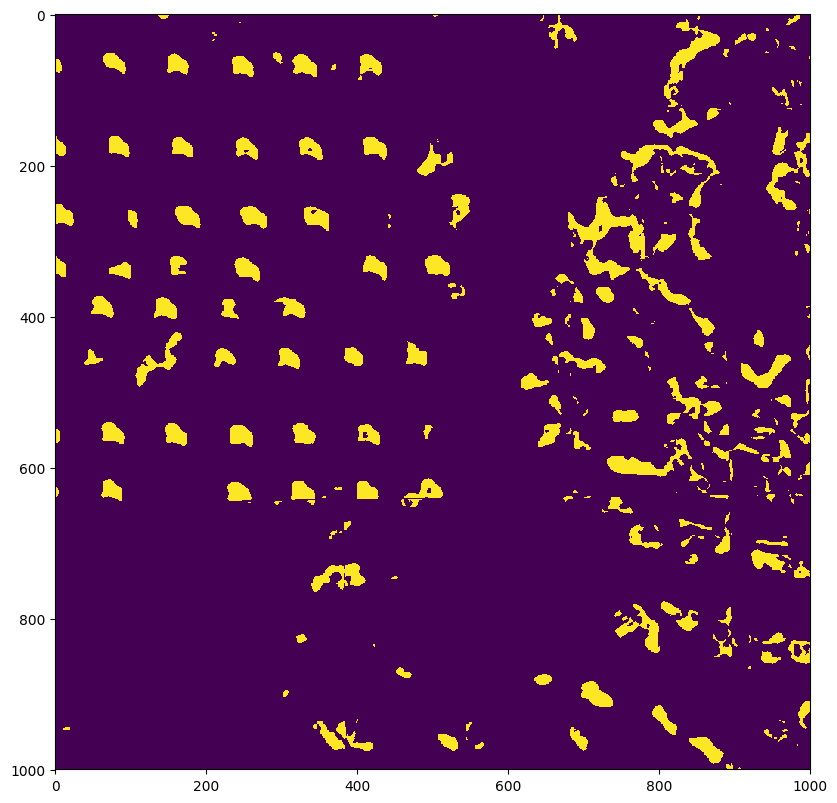

In [253]:
plot_image(cut(image))

# Clean Mask and Find Centers

2019-09-27 13:48:01,010 - am-segm - INFO - Applying erosion and dilation


(<Figure size 1600x1000 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5ef4ac56d8>)

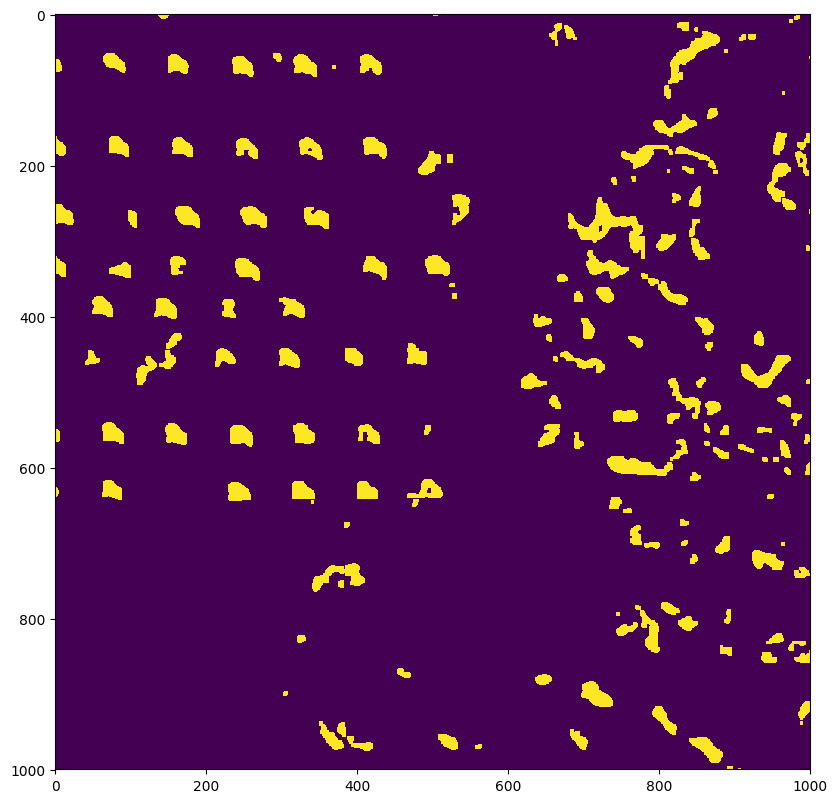

In [254]:
image = erode_dilate(image)
plot_image(cut(image))

2019-09-27 13:48:10,068 - am-segm - INFO - Removing noisy ablation marks
2019-09-27 13:48:10,090 - am-segm - INFO - axis=0, min=426, max=7142
2019-09-27 13:48:10,143 - am-segm - INFO - axis=1, min=396, max=4851


(<Figure size 1600x1000 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5ef25a1c18>)

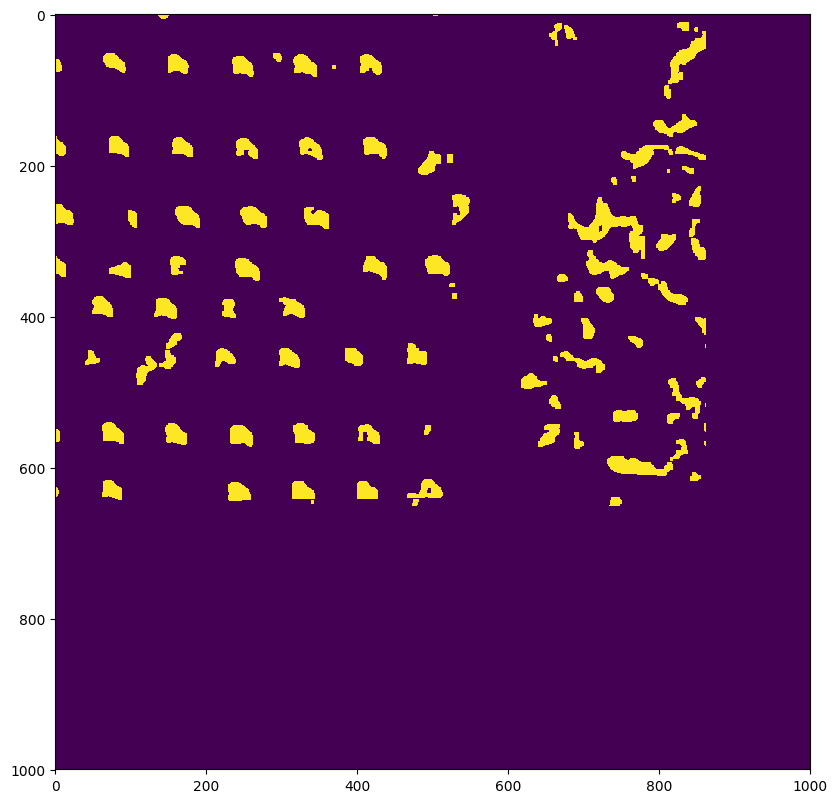

In [255]:
image = remove_noisy_marks(image)
plot_image(cut(image))

In [96]:
# calculate_axis_thresholds(image, )

In [97]:
# row_mask = calculate_axis_mask(image, am_centers, target_axis=0)

In [98]:
# col_mask = calculate_axis_mask(image, am_centers, target_axis=1)

In [99]:
am_centers = find_am_centers(image)
len(am_centers)

2019-09-26 19:27:51,948 - am-segm - INFO - Finding AM centers


3870

In [100]:
# am_centers = am_centers[row_mask & col_mask]
# am_centers.shape
# min_max(am_centers[:,0]), min_max(am_centers[:,1])

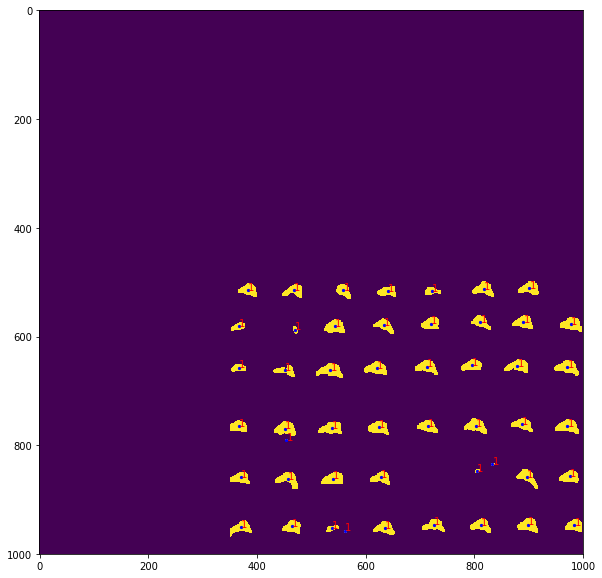

In [102]:
labels = np.ones(am_centers.shape[0], dtype=int)
plot_am_labels(image, am_centers, labels, row_offset, col_offset, patch_size)

# Cluster AM Centers

In [103]:
am_centers.shape

(3870, 2)

In [104]:
target_axis = 0  # target axis: (1 = columns = X-axis, 0 = rows = Y-axis)
acq_grid_shape[target_axis]

80

In [105]:
y_labels = cluster_coords(am_centers[:,target_axis], acq_grid_shape[target_axis], sample_ratio=1)

2019-09-26 19:28:42,773 - am-segm - INFO - Clustering (3870,) array into 80 clusters


In [106]:
y_axis_coords = am_centers[:,target_axis]

In [107]:
target_axis = 1  # target axis: (1 = columns = X-axis, 0 = rows = Y-axis)
acq_grid_shape[target_axis]

50

In [108]:
x_labels = cluster_coords(am_centers[:,target_axis], acq_grid_shape[target_axis], sample_ratio=1)

2019-09-26 19:28:44,132 - am-segm - INFO - Clustering (3870,) array into 50 clusters


In [109]:
x_axis_coords = am_centers[:,target_axis]

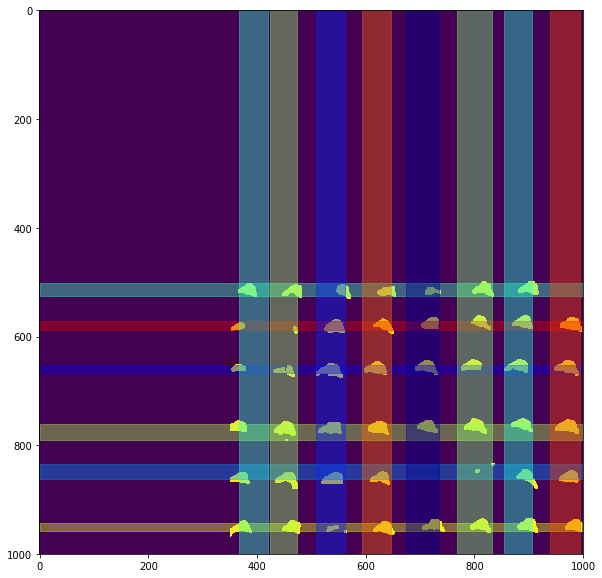

In [110]:
# patch = cut_patch(image, row_offset, col_offset-1000, 2000)
patch = cut(image)
ax = plot_image(patch)
plot_labels(ax, patch, 0, y_axis_coords, y_labels, set(y_labels))
plot_labels(ax, patch, 1, x_axis_coords, x_labels, set(x_labels))

In [111]:
acq_y_grid = convert_labels_to_grid(y_axis_coords, y_labels)
acq_x_grid = convert_labels_to_grid(x_axis_coords, x_labels)
acq_indices = convert_grid_to_indices(acq_y_grid, acq_x_grid, acq_grid_shape[1])

2019-09-26 19:28:56,258 - am-segm - INFO - Converting labels to grid values
2019-09-26 19:28:56,260 - am-segm - INFO - Converting labels to grid values
2019-09-26 19:28:56,262 - am-segm - INFO - Converting grid values to indices


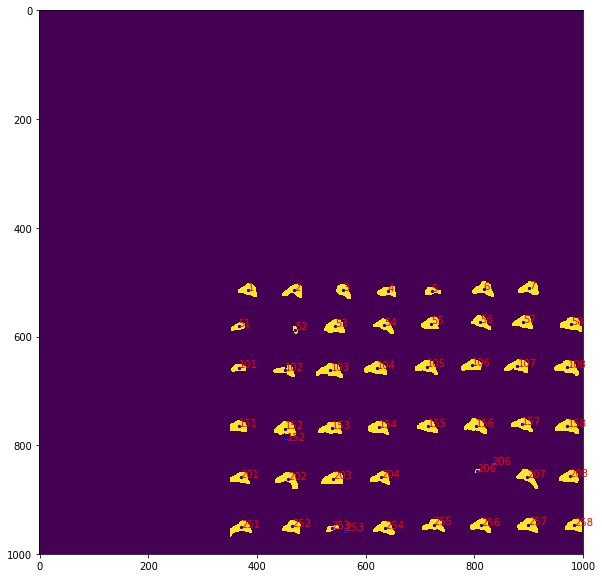

In [112]:
plot_am_labels(cut(image), am_centers, acq_indices, row_offset, col_offset, patch_size)

# Rotate Image and AM Centers Back

In [113]:
best_angle

0.8

In [114]:
image = rotate_image(image, -best_angle)

In [115]:
# plot_image(cut_patch(image))

In [116]:
am_centers = rotate_am_centers(am_centers, -best_angle, image.shape)
# am_centers

2019-09-26 19:29:07,163 - am-segm - INFO - Rotating AM centers on -0.800 angle


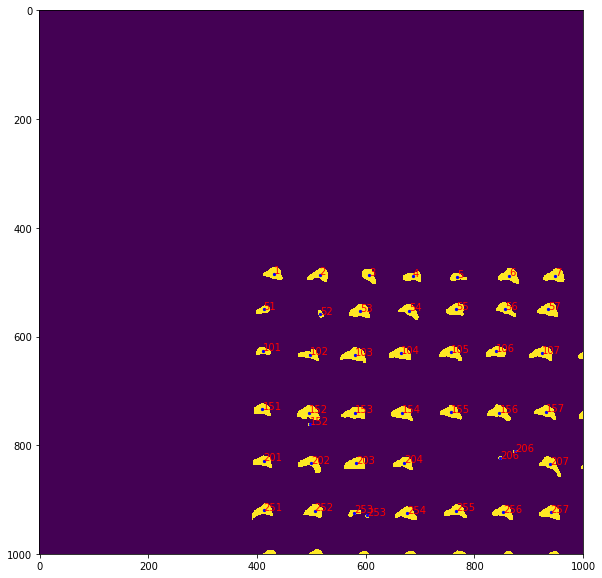

In [117]:
plot_am_labels(cut(image), am_centers, acq_indices, row_offset, col_offset, patch_size)

# Fill Mask with Acqusition Indices

In [118]:
acq_indices.shape

(3870,)

In [125]:
acq_index_mask_coo = create_acq_index_mask(image, am_centers, acq_indices)

2019-09-26 19:32:27,759 - am-segm - INFO - Creating acquisition index mask


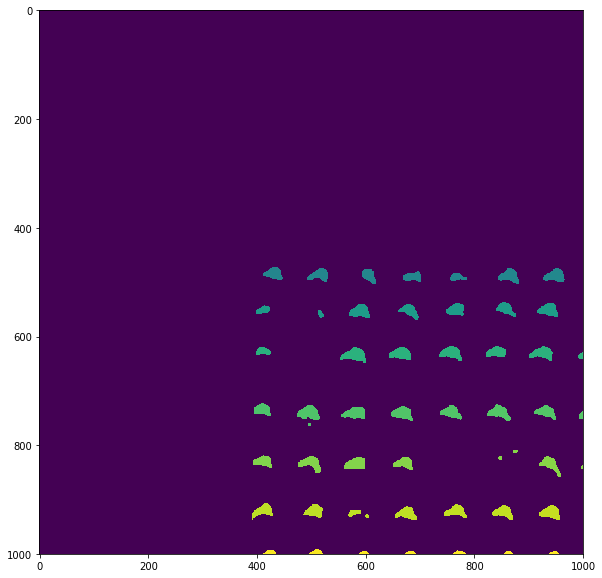

In [145]:
img = acq_index_mask_coo.toarray()
img[img == 0] = -255  # to make the first row with small marker values visible
plot_image(cut(img));

In [123]:
row_offset, col_offset, patch_size

(0, 0, 1000)

In [179]:
image.shape, acq_grid_shape

((7680, 5156), (80, 50))

In [230]:
plot_am_labels(
    mask=image, centers=am_centers, labels=acq_indices, source=source,
    row_offset=row_offset, col_offset=col_offset, patch_size=1000
);
plt.axis('off')
plt.savefig(
    '/tmp/image.png',
    bbox_inches='tight',
)
plt.close()

In [177]:
# import matplotlib.pyplot as plt

# for dpi in [72,100,144]:

#     fig,ax = plt.subplots(figsize=(1.5,2), dpi=dpi)
#     ax.set_title("fig.dpi={}".format(dpi))

#     ax.set_ylim(-3,3)
#     ax.set_xlim(-2,2)

#     ax.scatter([0],[1], s=10**2, 
#                marker="s", linewidth=0, label="100 points^2")
#     ax.scatter([1],[1], s=(10*72./fig.dpi)**2, 
#                marker="s", linewidth=0, label="100 pixels^2")

#     ax.legend(loc=8, framealpha=1, fontsize=8)

#     fig.savefig("fig{}.png".format(dpi), bbox_inches="tight")

# plt.show() 

# Convert and Save Results

In [136]:
import operator

In [137]:
%%time
am_x_y_coords = []
for acq_idx in range(1, operator.mul(*acq_grid_shape) + 1):
    pixel_inds = (markers_coo.data == acq_idx).nonzero()[0]
    ys = markers_coo.row[pixel_inds]
    xs = markers_coo.col[pixel_inds]
    am_x_y_coords.append([xs, ys])

CPU times: user 26.7 s, sys: 73.5 ms, total: 26.8 s
Wall time: 26.8 s


In [138]:
np.save('marks_mask.npy', am_x_y_coords)

In [139]:
am_x_y_coords = np.load('marks_mask.npy')

In [140]:
am_x_y_coords[0]

array([array([185, 186, 187, ..., 204, 205, 206], dtype=int32),
       array([269, 269, 269, ..., 311, 311, 311], dtype=int32)],
      dtype=object)

In [141]:
m = np.zeros_like(markers)
for idx, (xs, ys) in enumerate(am_x_y_coords, 1):
    m[ys, xs] = idx

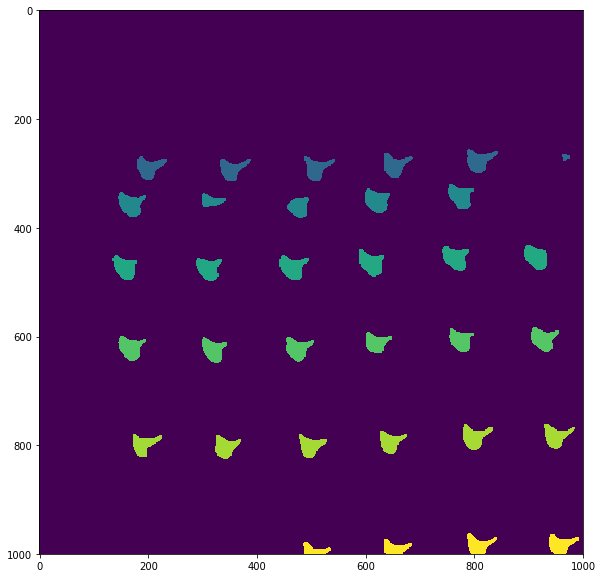

In [142]:
m[m == 0] = -255
plot_image(cut_patch(m))

In [335]:
# a = np.load('data/test_AM_image/marksMask.npy')
# a.shape
# xs, ys, = a[0]
# xs.shape, ys.shape
# xs